## Clustering

## K-Means application: create 'personas'.

The objective of this project is to segment users according to their online transactions in order to create marketing personas and personalize future marketing campaigns.

Libraries:

In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import pickle
import yaml

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

YAML file parameters:

In [3]:
try: 
    with open ("./../params.yaml", 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')

### 1. Load and transform data

For this clustering project we are going to use a sample Instacart dataset and the unsupervised learning algorithm K-Means. This sample includes the online transactions of about 50,000 users over a period of one year. 

In [4]:
instacart = pd.read_csv(config['data']['instacart_sample'])
print('Shape:', instacart.shape)
print('Transactions:', instacart['order_id'].nunique())
print('Users:', instacart['user_id'].nunique())
instacart.drop('Unnamed: 0', axis=1, inplace=True)
instacart.head()

Shape: (5204393, 15)
Transactions: 761900
Users: 49949


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,department_id,aisle_id,aisle,department
0,6,22352,4,1,12,30.0,15873,2,0,Dryer Sheets Geranium Scent,17,75.0,laundry,household
1,8,3107,5,4,6,17.0,23423,1,1,Original Hawaiian Sweet Rolls,3,43.0,buns rolls,bakery
2,13,45082,2,6,17,1.0,3800,12,0,Hampshire 100% Natural Sour Cream,16,108.0,other creams cheeses,dairy eggs
3,13,45082,2,6,17,1.0,25783,7,0,Lemon Lime Thirst Quencher,7,64.0,energy sports drinks,beverages
4,13,45082,2,6,17,1.0,23020,10,0,Diet Tonic Water,7,77.0,soft drinks,beverages


#### 1.1 Select and transform features for K Means algorithm

As mentioned above, the main goal of this project is to create 'marketing personas' in order to redirect Instacart's marketing strategy. Therefore, we need to classify each user according to their transactions.

After many iterations, these are the features that have provided the best results:

- Days_since_prior_order (purchase frequency).
- Add_to_cart_order (gives us the number of products purchased during a year)
- Top 4 departments by transactions

The next steps to perform are:

1. Group data by users and apply the aggregation functions needed.
2. Apply OneHotEncoder on categorical data.
3. Scale the data with MinMaxScaler.

We create a copy of the dataset we will work with from now on and apply the needed transformations to get one row per user.

In [5]:
instacart_km = instacart.copy()
instacart_km.drop(['reordered', 'product_id', 'department_id', 'aisle_id'], axis=1, inplace=True)
instacart_km.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,product_name,aisle,department
0,6,22352,4,1,12,30.0,2,Dryer Sheets Geranium Scent,laundry,household
1,8,3107,5,4,6,17.0,1,Original Hawaiian Sweet Rolls,buns rolls,bakery
2,13,45082,2,6,17,1.0,12,Hampshire 100% Natural Sour Cream,other creams cheeses,dairy eggs
3,13,45082,2,6,17,1.0,7,Lemon Lime Thirst Quencher,energy sports drinks,beverages
4,13,45082,2,6,17,1.0,10,Diet Tonic Water,soft drinks,beverages


Separate data to perform some mathematical operations and get the numbers we are interested in.

In [6]:
X_1 = instacart_km[['user_id', 'days_since_prior_order']]
X_1.head()

,user_id,days_since_prior_order
0,22352,30.0
1,3107,17.0
2,45082,1.0
3,45082,1.0
4,45082,1.0


In [7]:
X_2 = instacart_km[['department']]
X_2.head()

,department
0,household
1,bakery
2,dairy eggs
3,beverages
4,beverages


In [8]:
X_3 = instacart_km[['user_id','order_id','add_to_cart_order']]
X_3.head()

,user_id,order_id,add_to_cart_order
0,22352,6,2
1,3107,8,1
2,45082,13,12
3,45082,13,7
4,45082,13,10


#### X_1

We apply the following aggregation functions:
- User_id -> unique value
- Order_number -> max number
- Days_since_prior_order -> mean

In [9]:
X_1 = instacart_km.groupby('user_id').agg({'days_since_prior_order':'mean'})
X_1.head()

,days_since_prior_order
user_id,
1,20.400000
2,16.149606
3,11.916667
4,13.300000
5,14.454545


#### X_2

We apply OneHotEncoder on the categorical data and then add up each purchase made on each department by user.

In [10]:
ohe = OneHotEncoder(handle_unknown='ignore').fit(X_2)

filename = config['encoders']['ohe']
with open(filename, "wb") as file:
        pickle.dump(ohe,file)

X_2_enc = ohe.transform(X_2).toarray()
X_2_df = pd.DataFrame(X_2_enc, columns = ohe.get_feature_names_out())
X_2_df

,department_alcohol,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,...,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204388,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5204389,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5204390,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5204391,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
X_2_df['user_id'] = instacart_km['user_id']
X_2_df.head()

,department_alcohol,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,...,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks,user_id
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22352
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3107
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45082
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45082
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45082


In [12]:
X_2_df = X_2_df.groupby('user_id').sum()
X_2_df.head()

,department_alcohol,department_babies,department_bakery,department_beverages,department_breakfast,department_bulk,department_canned goods,department_dairy eggs,department_deli,department_dry goods pasta,...,department_household,department_international,department_meat seafood,department_missing,department_other,department_pantry,department_personal care,department_pets,department_produce,department_snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,10.0,3.0,0.0,0.0,9.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,21.0
2,0.0,0.0,1.0,5.0,2.0,0.0,1.0,35.0,14.0,0.0,...,0.0,3.0,1.0,0.0,0.0,8.0,0.0,0.0,16.0,39.0
3,0.0,0.0,0.0,3.0,0.0,0.0,0.0,9.0,2.0,4.0,...,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,20.0,9.0
4,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,2.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.0,...,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,16.0,1.0


There are too many columns, let's look at which are the most popular departments and stick with the first 4.

In [13]:
dpt_top5 = [round(sum(X_2_df[elem]),2) for elem in X_2_df.columns]
dpt_top5 = list(zip(X_2_df.columns, dpt_top5))
dpt_top5

[('department_alcohol', 20654.0),
 ('department_babies', 62711.0),
 ('department_bakery', 199674.0),
 ('department_beverages', 423476.0),
 ('department_breakfast', 113181.0),
 ('department_bulk', 6702.0),
 ('department_canned goods', 187084.0),
 ('department_dairy eggs', 864310.0),
 ('department_deli', 179401.0),
 ('department_dry goods pasta', 137602.0),
 ('department_frozen', 369971.0),
 ('department_household', 120199.0),
 ('department_international', 45148.0),
 ('department_meat seafood', 120513.0),
 ('department_missing', 9450.0),
 ('department_other', 5154.0),
 ('department_pantry', 303767.0),
 ('department_personal care', 74308.0),
 ('department_pets', 16620.0),
 ('department_produce', 1490845.0),
 ('department_snacks', 453623.0)]

Departments selected:
1. department_produce
2. department_dairy eggs
3. department_frozen
4. department_snacks

In [14]:
X_2_df = X_2_df[['department_produce', 'department_dairy eggs', 'department_frozen',
                'department_snacks']]
X_2_df.head()

,department_produce,department_dairy eggs,department_frozen,department_snacks
user_id,,,,
1,4.0,9.0,0.0,21.0
2,16.0,35.0,11.0,39.0
3,20.0,9.0,4.0,9.0
4,1.0,0.0,1.0,1.0
5,16.0,5.0,2.0,1.0


#### X_3

Compute total number of purchases by user.

In [15]:
X_3.head()

,user_id,order_id,add_to_cart_order
0,22352,6,2
1,3107,8,1
2,45082,13,12
3,45082,13,7
4,45082,13,10


In [16]:
X_3_df = X_3.groupby(['user_id', 'order_id']).max()

In [17]:
X_3_df = X_3_df.reset_index()
X_3_df.head(10)

,user_id,order_id,add_to_cart_order
0,1,431534,8
1,1,473747,5
2,1,550135,5
3,1,2254736,5
4,1,2295261,6
5,1,2398795,6
6,1,2539329,5
7,1,2550362,9
8,1,3108588,4
9,1,3367565,4


In [18]:
X_3_df = X_3_df.groupby('user_id').agg({'add_to_cart_order':'sum'})
X_3_df = X_3_df.rename(columns = {'add_to_cart_order':'num_prods_purchased'})
X_3_df.head()

,num_prods_purchased
user_id,
1,57
2,188
3,81
4,18
5,36


In [19]:
X_3_df.shape

(49949, 1)

#### 1.2 Merge and scale data

Combine the three datasets and apply MinMaxScaler

In [20]:
X = X_1.join(X_2_df)
X = X.join(X_3_df['num_prods_purchased'])
print(X.shape)
X.head()

(49949, 6)


,days_since_prior_order,department_produce,department_dairy eggs,department_frozen,department_snacks,num_prods_purchased
user_id,,,,,,
1,20.400000,4.0,9.0,0.0,21.0,57
2,16.149606,16.0,35.0,11.0,39.0,188
3,11.916667,20.0,9.0,4.0,9.0,81
4,13.300000,1.0,0.0,1.0,1.0,18
5,14.454545,16.0,5.0,2.0,1.0,36


#### 1.3 Manage NaNs

The dataframe contains 34 NaN values that refer to the first purchase made by each user. We will impute these values manually with 0.

In [21]:
X.isna().sum()

days_since_prior_order    34
department_produce         0
department_dairy eggs      0
department_frozen          0
department_snacks          0
num_prods_purchased        0
dtype: int64

In [22]:
X['days_since_prior_order'] = X['days_since_prior_order'].fillna(0)
X.isna().sum()

days_since_prior_order    0
department_produce        0
department_dairy eggs     0
department_frozen         0
department_snacks         0
num_prods_purchased       0
dtype: int64

#### 1.4 Scaling data

In [23]:
scaler = MinMaxScaler()
scaler.fit(X)
    
filename = config['scalers']['minmax']
with open(filename, "wb") as file:
        pickle.dump(scaler,file)

X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)
X_scaled.head()

,days_since_prior_order,department_produce,department_dairy eggs,department_frozen,department_snacks,num_prods_purchased
0,0.680000,0.006547,0.009868,0.000000,0.040385,0.019823
1,0.538320,0.026187,0.038377,0.045643,0.075000,0.066195
2,0.397222,0.032733,0.009868,0.016598,0.017308,0.028319
3,0.443333,0.001637,0.000000,0.004149,0.001923,0.006018
4,0.481818,0.026187,0.005482,0.008299,0.001923,0.012389


In [24]:
X_num = X_scaled.copy()
X_num = X_num[['num_prods_purchased', 'days_since_prior_order']]

Training a K-Means model with 2 neighbours.
Training a K-Means model with 3 neighbours.
Training a K-Means model with 4 neighbours.
Training a K-Means model with 5 neighbours.
Training a K-Means model with 6 neighbours.
Training a K-Means model with 7 neighbours.
Training a K-Means model with 8 neighbours.


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

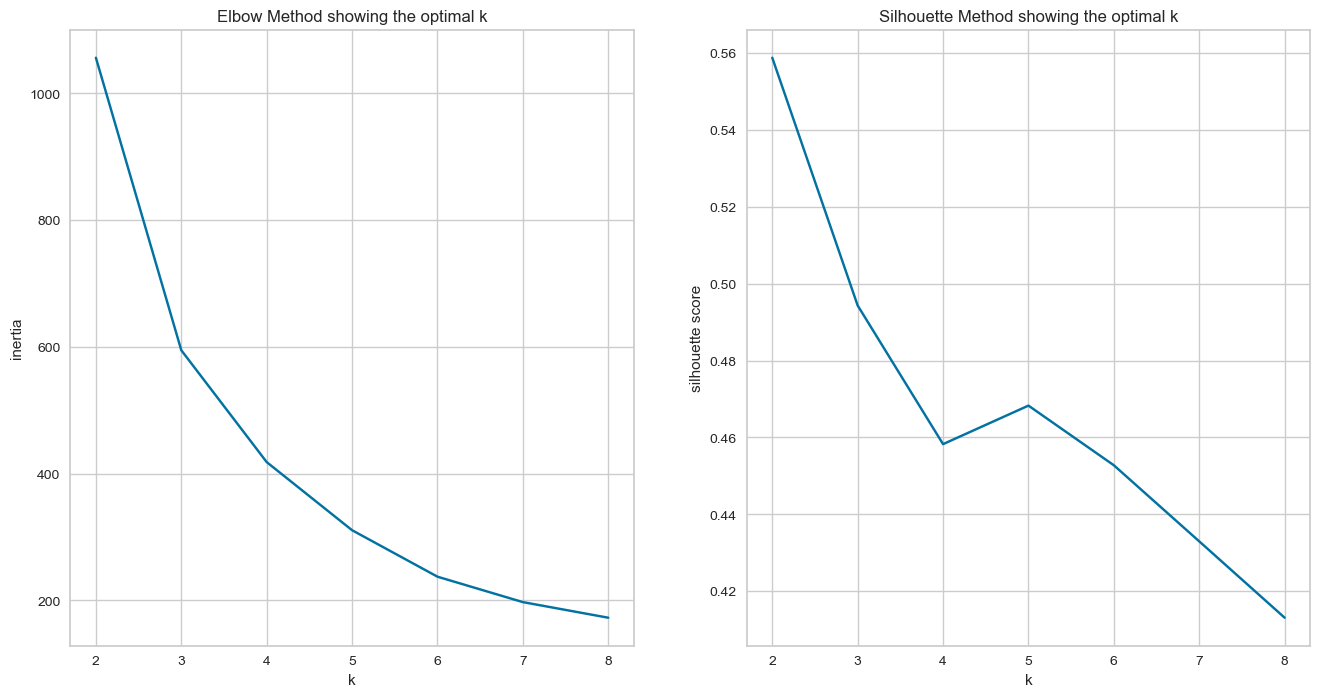

In [25]:
K = range(2, 9)
inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} neighbours.".format(k))
    kmeans = KMeans(n_clusters = k,
                    random_state = config['models']['kmeans_randomstate'])
    kmeans.fit(X_num)
#     filename = config['models']['kmeans_path'] + str(k) + ".pickle"
#     with open(filename, "wb") as file:
#         pickle.dump(kmeans,file)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_num, kmeans.predict(X_num)))

# Plot the results
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

# Delete days_since_prior_order

In [58]:
X_scaled_1 = X_scaled.copy()
X_scaled_1.drop('days_since_prior_order', axis=1, inplace=True)
X_scaled_1.head()

,department_produce,department_dairy eggs,department_frozen,department_snacks,num_prods_purchased
0,0.006547,0.009868,0.000000,0.040385,0.019823
1,0.026187,0.038377,0.045643,0.075000,0.066195
2,0.032733,0.009868,0.016598,0.017308,0.028319
3,0.001637,0.000000,0.004149,0.001923,0.006018
4,0.026187,0.005482,0.008299,0.001923,0.012389


Training a K-Means model with 2 neighbours.
Training a K-Means model with 3 neighbours.
Training a K-Means model with 4 neighbours.
Training a K-Means model with 5 neighbours.
Training a K-Means model with 6 neighbours.
Training a K-Means model with 7 neighbours.
Training a K-Means model with 8 neighbours.


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

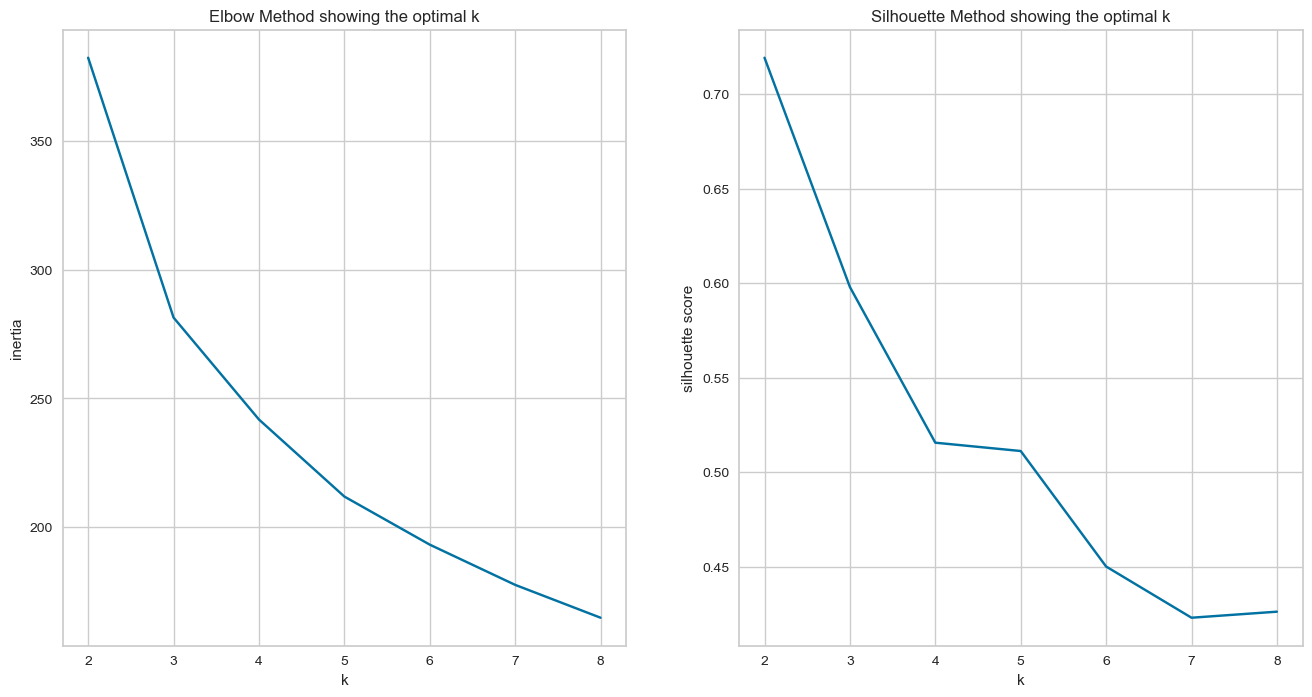

In [60]:
K = range(2, 9)
inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} neighbours.".format(k))
    kmeans = KMeans(n_clusters = k,
                    random_state = config['models']['kmeans_randomstate'])
    kmeans.fit(X_scaled_1)
    filename = config['models']['kmeans_path'] + str(k) + ".pickle"
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_1, kmeans.predict(X_scaled_1)))

# Plot the results
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

In [63]:
with open('../models/kmeans_scaled_4.pickle', 'rb') as f:
    km4 = pickle.load(f)
    
km4y_means = km4.labels_
km4y_means

array([0, 3, 0, ..., 3, 1, 0])

In [70]:
user_id = instacart['user_id'].unique()
id_label_new = pd.DataFrame(user_id, columns = ['user_id'])
id_label_new['cluster'] = km4y_means
id_label_new['num_prods_purchased'] = X_3_df['num_prods_purchased']
id_label_new.head()
instacart_km_new = instacart_km.merge(id_label_new, how='left', on='user_id')
instacart_km_new.to_csv(config['data']['instacart_labels_excel'])

In [71]:
X_scaled_2 = X_scaled_1.copy()
X_scaled_2.drop('num_prods_purchased', axis=1, inplace=True)
X_scaled_2.head()

,department_produce,department_dairy eggs,department_frozen,department_snacks
0,0.006547,0.009868,0.000000,0.040385
1,0.026187,0.038377,0.045643,0.075000
2,0.032733,0.009868,0.016598,0.017308
3,0.001637,0.000000,0.004149,0.001923
4,0.026187,0.005482,0.008299,0.001923


Training a K-Means model with 2 neighbours.
Training a K-Means model with 3 neighbours.
Training a K-Means model with 4 neighbours.
Training a K-Means model with 5 neighbours.
Training a K-Means model with 6 neighbours.
Training a K-Means model with 7 neighbours.


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

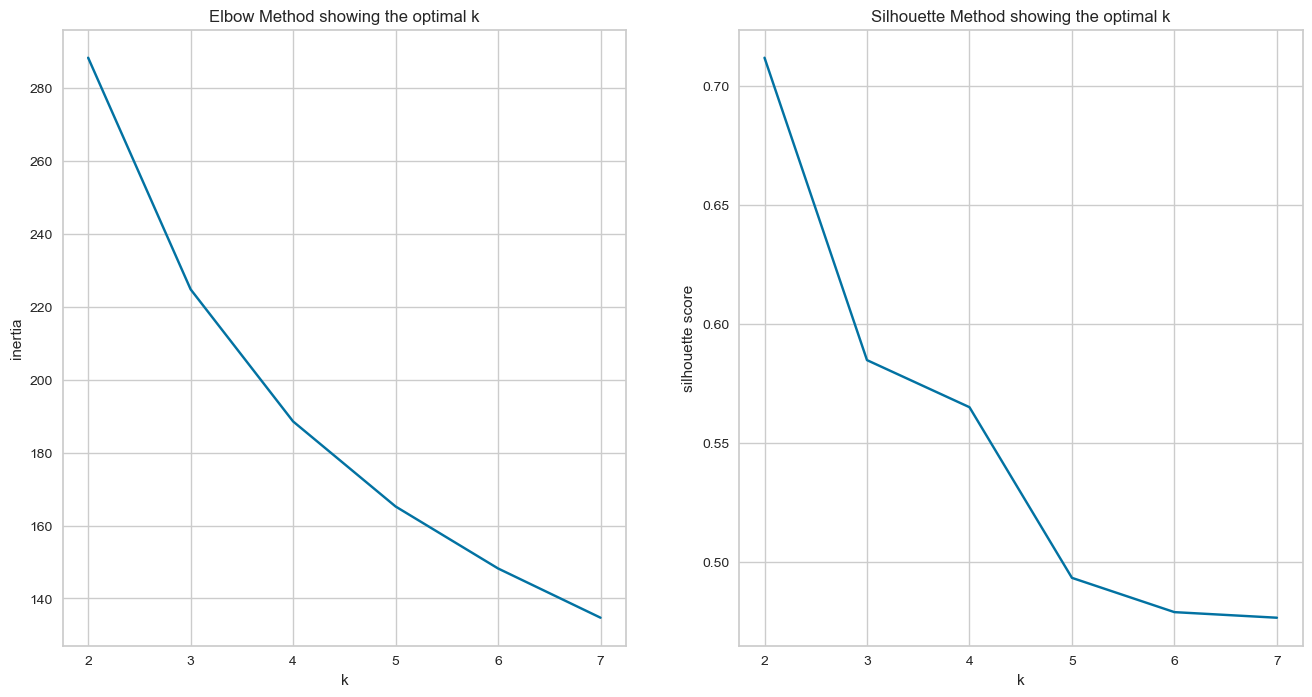

In [72]:
K = range(2, 8)
inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} neighbours.".format(k))
    kmeans = KMeans(n_clusters = k,
                    random_state = config['models']['kmeans_randomstate'])
    kmeans.fit(X_scaled_2)
#     filename = config['models']['kmeans_path'] + str(k) + ".pickle"
#     with open(filename, "wb") as file:
#         pickle.dump(kmeans,file)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled_2, kmeans.predict(X_scaled_2)))

# Plot the results
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

## 2. Clustering - K-Means

K-Means is a non-parametric algorithm, so we cannot define a priori the parameters of the model. We will create a for-loop to test different numbers of clusters.

Training a K-Means model with 2 neighbours.
Training a K-Means model with 3 neighbours.
Training a K-Means model with 4 neighbours.
Training a K-Means model with 5 neighbours.
Training a K-Means model with 6 neighbours.
Training a K-Means model with 7 neighbours.
Training a K-Means model with 8 neighbours.


Text(0.5, 1.0, 'Silhouette Method showing the optimal k')

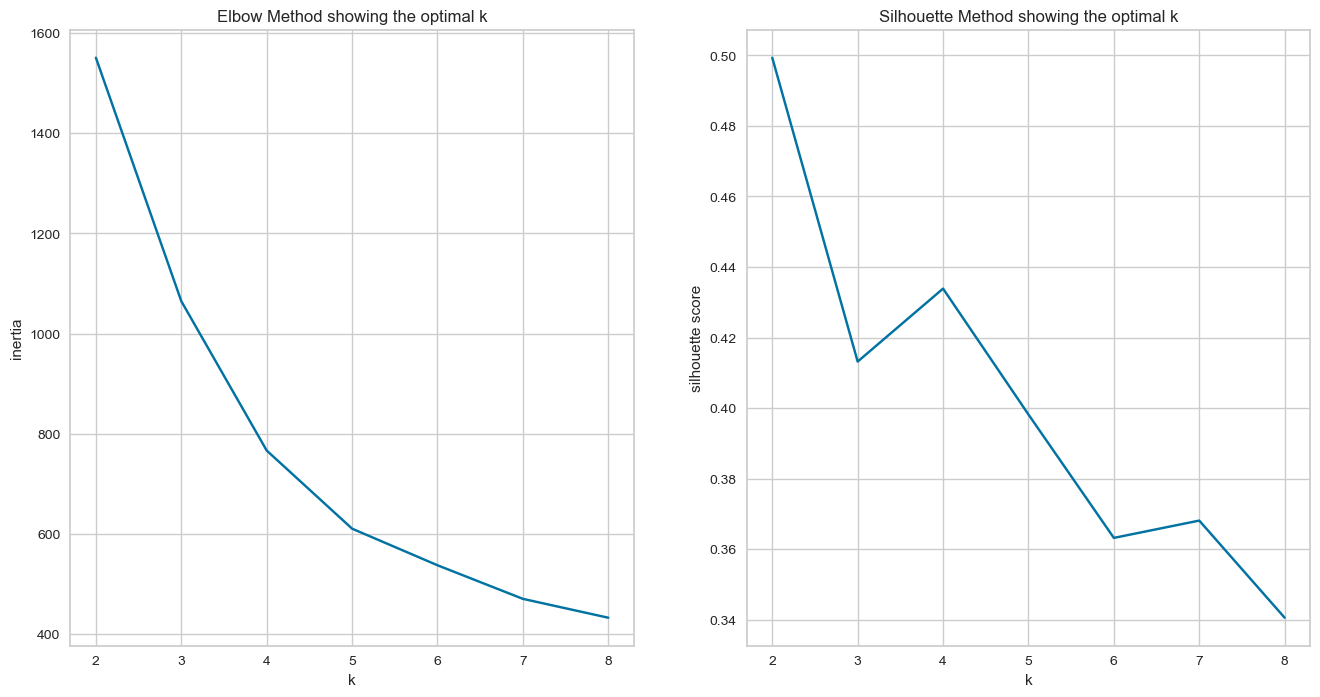

In [48]:
K = range(2, 9)
inertia = []
silhouette = []

for k in K:
    print("Training a K-Means model with {} neighbours.".format(k))
    kmeans = KMeans(n_clusters = k,
                    random_state = config['models']['kmeans_randomstate'])
    kmeans.fit(X_scaled)
    filename = config['models']['kmeans_path'] + str(k) + ".pickle"
    with open(filename, "wb") as file:
        pickle.dump(kmeans,file)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(X_scaled, kmeans.predict(X_scaled)))

# Plot the results
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].plot(K, inertia, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[0].set_title('Elbow Method showing the optimal k')
ax[1].plot(K, silhouette, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('silhouette score')
ax[1].set_xticks(np.arange(min(K), max(K)+1, 1.0))
ax[1].set_title('Silhouette Method showing the optimal k')

A good model is one that has a low inertia value and a small number of clusters. If we look at the inertia and the silhoutte score, the optimal number of K ranges from 4 to 7 (5 being the point at which the reduction of inertia becomes smaller and smaller). 

We will visualize the clusters and according to the size of each cluster, we will choose the number of clusters (K).

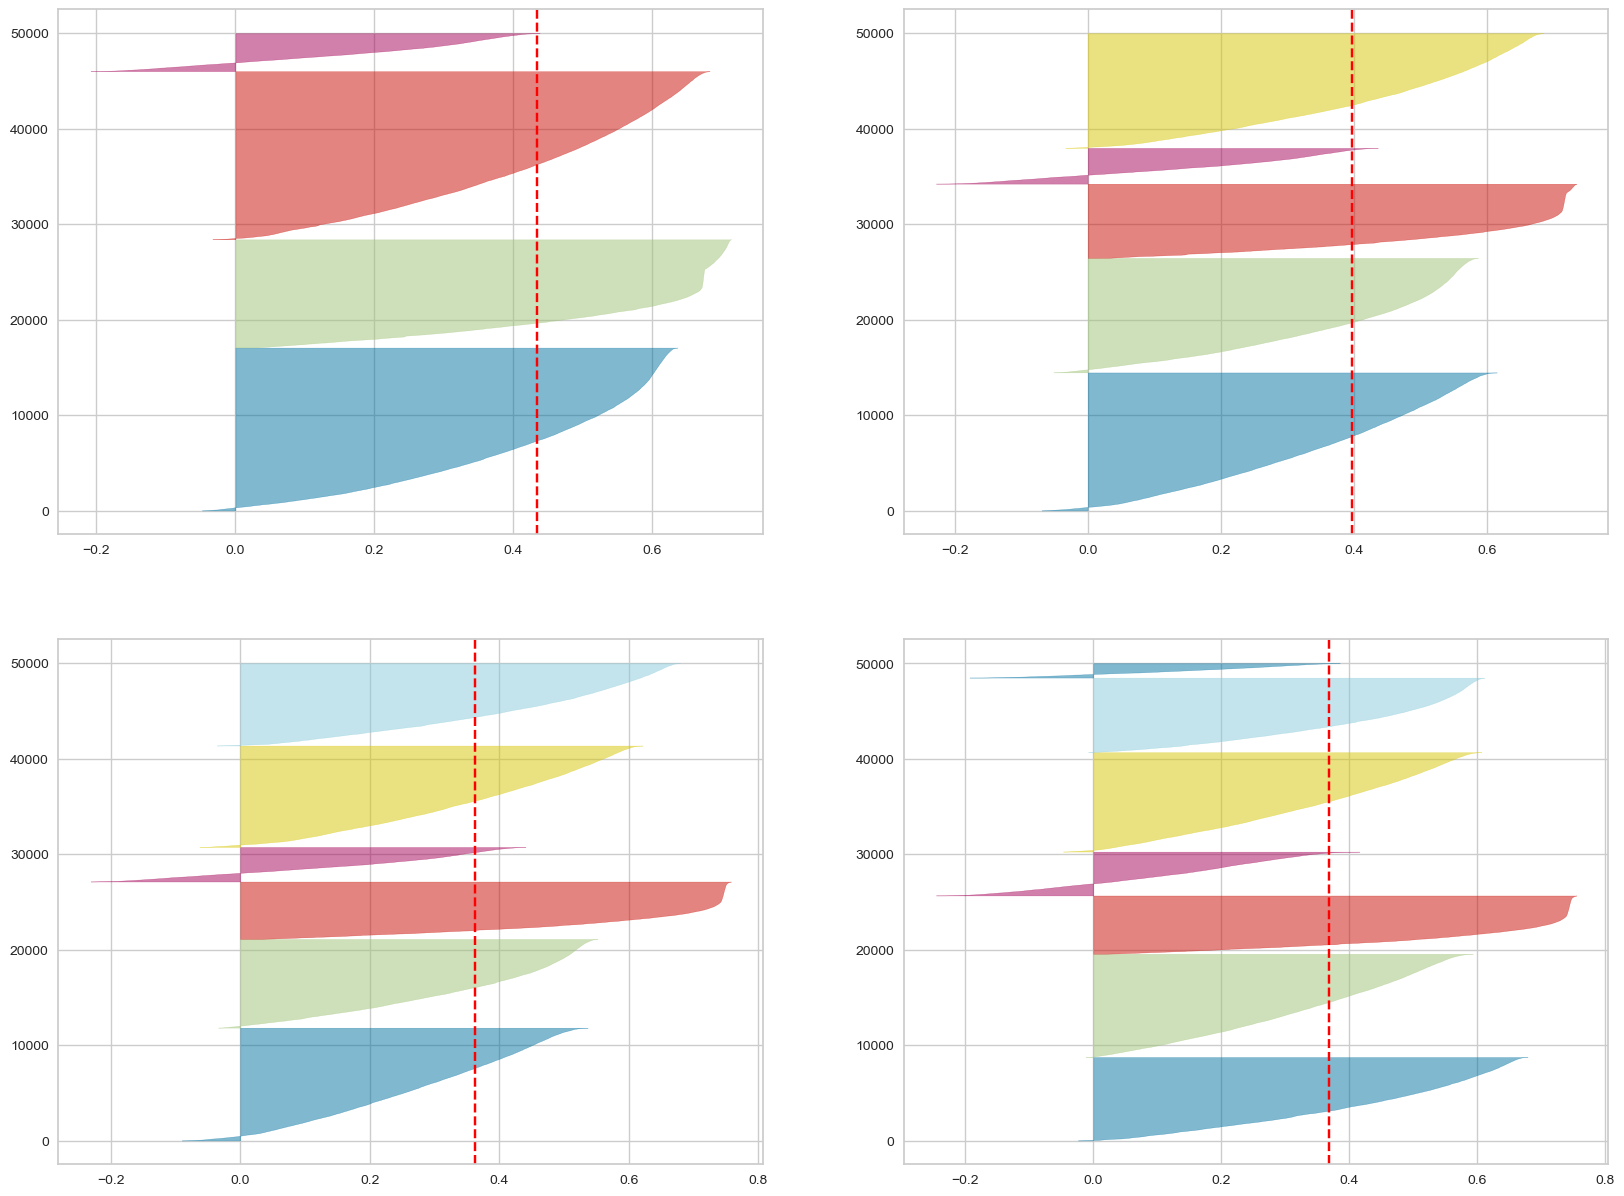

In [49]:
fig, ax = plt.subplots(2, 2, figsize=(20,15))
axs = 2 
for i in [4,5,6,7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, random_state=1234)
          
    q, mode = divmod(axs, 2)
    
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mode])
    visualizer.fit(X_scaled)
    axs+=1

If we look at the figure with 7 clusters, we can see that two of of the clusters (0 and 3) are not well defined. Even so, this model is the one that, in general terms, shows a more balanced distribution in each cluster and lees intertia, so we will choose to use this one in the project.

In [50]:
with open(config['models']['kmeans_path_k'], 'rb') as f:
    km7 = pickle.load(f)
    
km7

KMeans(n_clusters=7, random_state=1234)

In [51]:
y_means = km7.labels_
y_means

array([0, 4, 1, ..., 1, 6, 4])

### Transform final dataset and assign cluster-labels.

Unique users.

In [52]:
user_id = instacart['user_id'].unique()

In [55]:
id_label = pd.DataFrame(user_id, columns = ['user_id'])
id_label['cluster'] = y_means
id_label['num_prods_purchased'] = X_3_df['num_prods_purchased']
id_label.head()

,user_id,cluster,num_prods_purchased
0,22352,0,NaN
1,3107,4,57.0
2,45082,1,188.0
3,18194,1,81.0
4,30822,4,18.0


In [54]:
instacart_km.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,product_name,aisle,department,cluster
0,6,22352,4,1,12,30.0,2,Dryer Sheets Geranium Scent,laundry,household,0
1,8,3107,5,4,6,17.0,1,Original Hawaiian Sweet Rolls,buns rolls,bakery,4
2,13,45082,2,6,17,1.0,12,Hampshire 100% Natural Sour Cream,other creams cheeses,dairy eggs,1
3,13,45082,2,6,17,1.0,7,Lemon Lime Thirst Quencher,energy sports drinks,beverages,1
4,13,45082,2,6,17,1.0,10,Diet Tonic Water,soft drinks,beverages,1


In [35]:
instacart_km = instacart_km.merge(id_label, how='left', on='user_id')
instacart_km.head(20)

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,add_to_cart_order,product_name,aisle,department,cluster
0,6,22352,4,1,12,30.0,2,Dryer Sheets Geranium Scent,laundry,household,0
1,8,3107,5,4,6,17.0,1,Original Hawaiian Sweet Rolls,buns rolls,bakery,4
2,13,45082,2,6,17,1.0,12,Hampshire 100% Natural Sour Cream,other creams cheeses,dairy eggs,1
3,13,45082,2,6,17,1.0,7,Lemon Lime Thirst Quencher,energy sports drinks,beverages,1
4,13,45082,2,6,17,1.0,10,Diet Tonic Water,soft drinks,beverages,1
5,13,45082,2,6,17,1.0,2,Chunky Salsa Medium,preserved dips spreads,pantry,1
6,13,45082,2,6,17,1.0,1,Light,beers coolers,alcohol,1
7,13,45082,2,6,17,1.0,4,Soda,soft drinks,beverages,1
8,13,45082,2,6,17,1.0,13,Original Potato Chips,chips pretzels,snacks,1
9,13,45082,2,6,17,1.0,6,G Series Lime Cucumber Sports Drink,energy sports drinks,beverages,1


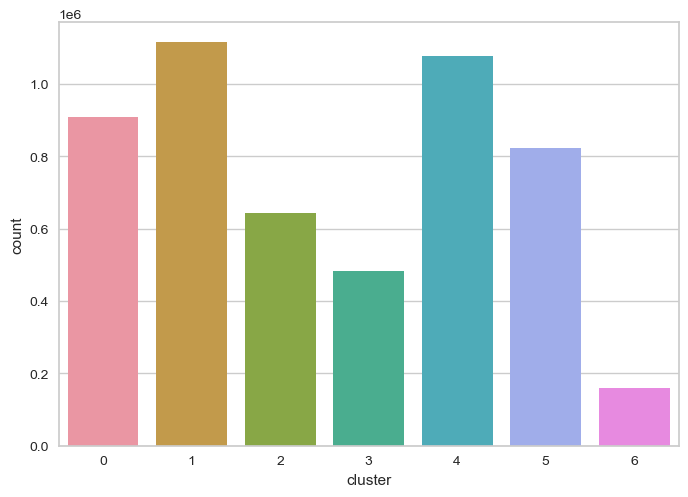

In [36]:
sns.countplot(instacart_km['cluster'])
plt.show()

In [39]:
instacart_km.to_csv(config['data']['instacart_labels'])

# ------------------------------------------------------------------------------

In [57]:
with open('../models/kmeans_scaled_4.pickle', 'rb') as f:
    km4 = pickle.load(f)
    
km4

KMeans(n_clusters=4, random_state=1234)